# 自行搭建的模型（手搓模型）
**注意：本文件为本小组的核心探究文件**

为保证代码运行的稳定性，建议您使用以下版本的python及其库：

| 名称 | python | numpy | pandas | matplotlib | seaborn |
| ------- | ------- | ------- | ------- | ------- | ------- |
| 版本号 | 3.13.5 | 2.1.3 | 2.2.3 | 3.10.0 | 0.13.2 |

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # 仅作绘图用

## 数据预处理函数部分
数据预处理包括以下四个板块：
* 数据归一化
* 数据读取
* 数据集分割
* 数据写入

In [ ]:
# 数据归一化
parameter = [1, 0]
def data_process(basic_data, refresh=True, para=parameter):
    # 所有输入应使用相同的归一化方法
    if refresh:
        para[0] = np.max(basic_data, axis=0)
        para[1] = np.min(basic_data, axis=0)
    processed_data = (basic_data - para[1]) / (para[0] - para[1]) * 0.9 + 0.05
    processed_data = np.nan_to_num(processed_data)
    return processed_data
    #数据处理到0.05~0.95

In [3]:
# 读取文档内的数据
def load_data(csv_type):
    if csv_type == "train":
        train_df = pd.read_csv('train.csv')
        train_df = train_df.drop("timecc", axis=1) # 全是0，无意义
        win_or_lose = train_df.iloc[:, 1].values.reshape(-1, 1)
        basic_data = train_df.iloc[:, 2:31].values
        processed_data = data_process(basic_data)
        return win_or_lose, processed_data
    elif csv_type == "test":
        test_df = pd.read_csv('test_template.csv')
        test_df = test_df.drop("timecc", axis=1)
        basic_data = test_df.iloc[:, 2:31].values
        processed_data = data_process(basic_data, refresh=False)
        return processed_data
    else:
        return 0 # 返回0，表示输入不合法

In [4]:
# 数据分割
def data_pretreat(win_or_lose, basic_data, train_percent):
    combined = np.concatenate((basic_data, win_or_lose), axis=1)
    np.random.shuffle(combined)#随机打乱测试集便于随机分割
    split_idx = int(len(combined) * train_percent)
    train_data = combined[:split_idx]
    validation_data = combined[split_idx:]
    train_features, train_labels = train_data[:, :-1], train_data[:, -1:]
    val_features, val_labels = validation_data[:, :-1], validation_data[:, -1:]
    return [train_labels, train_features], [val_labels, val_features]
    # 按照train_percent将train.csv分割为训练集和验证集

In [5]:
# 结果存储
def writeDown(index, data):
    result_df = pd.DataFrame({
        'id': index,
        'win': data
    })
    result_df.to_csv('predictions.csv', index=False)
    print("预测结果已保存到 predictions.csv")

## 辅助函数部分
本部分为之后会用到的辅助函数，包括以下内容：
* np列表复制函数，用于更新最新模型等部分
* 0，1矩阵生成函数，用于dropout层

In [6]:
# 模型参数复制函数
def copy_arrays(array_list):
    res = []
    for array in array_list:
        res.append(array.copy())
    return res

In [7]:
# 生成0，1矩阵，用于dropout
def zeroOneMat(size, count):
    array = np.array([0] * count[0] + [1] * count[1])
    np.random.shuffle(array)
    array = array.reshape(size[0], size[1])
    return array

## 模型类搭建部分
本部分为本文件的核心部分，用于模型自身的实现，包括以下部分：
* 初始化
* 前向与反向传播
* 训练与验证方法
* 模型可视化部分

In [8]:
# 训练模型构建
class Model:
    def __init__(self, layer_num, step, momentum, drop_rate, factor, l2_para, sigma, d_sigma, in_channel, target_channel, result_channel):
        self.in_channel = in_channel # 输入通道
        self.target_channel = target_channel # 计算中通道
        self.result_channel = result_channel # 输出通道
        
        self.losses = [] # 记录损失函数变化，以便完成可视化工作，每轮循环中无需清空
        self.successes = [] # 记录模型的求解成功率，以便完成可视化工作，每轮循环中无需清空
        self.accuracies = [] # 记录混淆矩阵，每轮循环中无需清空
        self.results = [] # 记录每层的计算结果，每轮循环中清空
        self.highest_acc = 0.0 # 记录模型最大准确率
        self.Loss = lambda y, y_hat: -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
        
        self.layer_num = layer_num # 记录模型层数
        self.step = step # 存储步长大小，初始化时读入
        self.momentum = momentum # 读入动量大小
        self.drop_rate = drop_rate # 读入dropout比例
        self.l2_para = l2_para # 读入L2正则化强度
        self.factor = factor # 读入截止因子
        self.sigma = sigma # 记录激活层函数
        self.d_sigma = d_sigma # 记录激活层函数导数

        self.parameters = [] # 模型参数存储列表
        self.grads = [] # 模型梯度储存列表
        for i in range(self.layer_num):
            shape = (self.result_channel if i == self.layer_num - 1 else self.target_channel, 
                    self.in_channel if i == 0 else self.target_channel)
            # 第一层为(traget, in)，最后一层为(result, target)，中间层为(target, target)
            # 上半段代码块使用Leaky Relu函数时启用，下半段代码块使用sigmoid函数时启用
            # w = np.abs(np.random.randn(shape[0], shape[1])) * np.sqrt(2.0 / in_channel) * 10
            # b = np.abs(np.random.randn(shape[0], 1)) * np.sqrt(2.0 / in_channel) * 10
            w = np.random.randn(shape[0], shape[1]) * np.sqrt(2.0 / (in_channel + result_channel)) * 10
            b = np.random.randn(shape[0], 1) * np.sqrt(2.0 / (in_channel + result_channel)) * 10
            para = [w, b] # 随机初始化参数
            
            self.parameters.append(para)
            grad = [np.zeros_like(w), np.zeros_like(b)]
            self.grads.append(grad)
        self.finest_model = [copy_arrays(array_list) for array_list in self.parameters]

    def calculate(self, data_input, write=True, dropout=True):
        x = data_input.copy()
        if write:
            self.results = [] # 若需要记录中间结果，则清空列表
        count = 0
        model = self.parameters if write else self.finest_model
        for w, b in model:
            z = np.dot(w, x) + b # z = wx + b
            if count == self.layer_num - 1:
                y = 1 / (1 + np.exp(-z)) # 最终层用此方法得到0~1之间的值
            else:
                y = self.sigma(z) # y = sigma(z)
                if dropout:
                    size = (self.target_channel, 1)
                    zeros = int(self.target_channel * self.drop_rate)
                    nums = (zeros, self.target_channel - zeros)
                    y = y * zeroOneMat(size, nums) / (1 - self.drop_rate) # dropout层
            if write:
                res = (x.copy(), z.copy())
                self.results.append(res)
            x = y.copy() # x_n = y_n-1
            if count == self.layer_num - 1 or not dropout:
                x[x > (1 - self.factor)] = (1 - self.factor)
                x[x < self.factor] = self.factor
            else:
                x[x > (1 - self.factor) / (1 - self.drop_rate)] = (1 - self.factor) / (1 - self.drop_rate)
                x[x < self.factor / (1 - self.drop_rate)] = self.factor / (1 - self.drop_rate)
            count += 1
        return x
        # 根据模型参数，对输入的数据进行运算，返回结果，输入shape=(in_channel, n)，输出shape=(result_channel, n)

    def getLoss(self, data):
        result, data_input = data
        result_hat = self.calculate(data_input, dropout=False)
        loss = self.Loss(result, result_hat).mean() # 计算损失函数
        self.losses.append(loss) # 将loss存入列表中

        res = (result_hat > 0.5).astype(int) # 大于0.5记为1，小于0.5记为0
        suc = res == result
        success = suc.sum() / suc.size # 计算预测成功率
        self.successes.append(success) # 将成功率存入列表
        # 获取混淆矩阵
        ans_matrix = [[((1 - res) * (1 - result)).sum(), ((1 - res) * result).sum()], 
                      [(res * (1 - result)).sum(), (res * result).sum()]]
        self.accuracies.append(ans_matrix)
        

    def getGrad(self, data):
        result, data_input = data
        result_hat = self.calculate(data_input)
        
        for index in range(self.layer_num - 1, -1, -1):
            x, z = self.results[index]
            w, b = self.parameters[index]
            # 开始计算梯度
            if index == self.layer_num - 1:
                grad_z = result_hat - result
            else:
                grad_z = grad_y * self.d_sigma(z)
            # 求z的梯度
            grad_x = np.dot(w.transpose(), grad_z)
            grad_w = np.dot(grad_z, x.transpose()) + self.l2_para * 2 * w
            grad_b = grad_z.sum(axis=1).reshape(b.shape) + self.l2_para * 2 * b
            # 引入L2正则化修正
            
            grad_y = grad_x # 反向传播梯度值
            self.grads[index][0] = self.grads[index][0] * self.momentum + grad_w * (1 - self.momentum)
            self.grads[index][1] = self.grads[index][1] * self.momentum + grad_b * (1 - self.momentum)

    def train(self, data):
        # 用于训练，调整参数
        self.getGrad(data)
        for i in range(self.layer_num):
            self.parameters[i][0] -= self.grads[i][0] * self.step
            self.parameters[i][1] -= self.grads[i][1] * self.step
            # 根据求得的grad，处理参数

    def validate(self, data):
        # 用于验证，计算损失函数
        self.getLoss(data)
        print("loss = %.4f, success = %.4f" %(self.losses[-1], self.successes[-1])) # 输出损失函数值，便于确认步长选择
        if self.successes[-1] > self.highest_acc:
            # 记录表现最好的模型，将其作用于实际应用
            self.highest_acc = self.successes[-1]
            self.finest_model = [copy_arrays(array_list) for array_list in self.parameters]

    def draw(self, saveFig=False):
        plt.figure(figsize=(12, 6))
        # 子图1：损失函数变化
        plt.subplot(1, 2, 1)
        plt.plot(self.losses, 'b-', linewidth=2) # losses是列表
        plt.title('Loss Function over Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Loss Value')
        plt.grid(True, linestyle='--', alpha=0.7)
        # 添加当前损失值标注
        last_loss = self.losses[-1]
        plt.annotate(f'Current: {last_loss:.4f}', 
                     xy=(len(self.losses)-1, last_loss),
                     xytext=(len(self.losses)*0.7, max(self.losses)*0.8),
                     arrowprops=dict(facecolor='black', shrink=0.05))
        # 子图2：预测成功率变化
        plt.subplot(1, 2, 2)
        plt.plot(self.successes, 'g-', linewidth=2)
        plt.title('Prediction Success Rate over Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Success Rate')
        plt.ylim(0, 1)  # 成功率在0-100%之间
        plt.grid(True, linestyle='--', alpha=0.7)
        # 添加当前成功率标注
        last_success = int(self.successes[-1] * 100)
        plt.annotate(f'Current: {last_success:d}%', 
                     xy=(len(self.successes)-1, last_success),
                     xytext=(len(self.successes)*0.7, 20),
                     arrowprops=dict(facecolor='black', shrink=0.05))
        # 添加整体标题
        plt.suptitle(f'Training Progress (Step Size: {self.step})', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # 为顶部标题留出空间
        if saveFig:
            plt.savefig("graph.SVG")
        plt.show()
        # 调用plt绘制损失函数与预测成功率随训练次数的变化
        
    def getConfusion(self, saveFig=False):
        # 读取混淆矩阵数据
        custom_confusion_matrix = np.array(self.accuracies[-1]).astype(int)
        # 类别标签
        class_labels = ['Lose', 'Win']
        # 创建热力图
        plt.figure(figsize=(8, 6))
        sns.heatmap(custom_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=class_labels, yticklabels=class_labels)
        # 添加标题和标签
        plt.title('Confusion Matrix')
        plt.xlabel('True Label')
        plt.ylabel('Predicted Label')
        # 显示与存储图形
        plt.tight_layout()
        if saveFig:
            plt.savefig("confuse.SVG")
        plt.show()

## 具体训练流程
以下部分为具体训练与测试流程，包括：
* 模型初始化
* 数据预处理
* 训练循环
* 模型可视化
* 模型存储
* 测试集产出

In [16]:
# 初始化设置
random_seed = 42
np.random.seed(random_seed) # 初始化随机种子
echo = 500 # 调整此处，改变训练轮数
step = 5e-4 # 调整此处，改变训练步长
layer_num = 2 # 调整此处，改变模型层数
momentum = 0.65 # 调整此处，改变动量大小
drop_rate = 0.0 # 调整此处，改变dropout率
l2_para = 0.03 # 调整此处，改变正则化强度系数
factor = 1e-6 # 调整此处，改变截止值

# 调整此处，改变激活函数，此处使用的是Leaky Relu/sigmoid函数，通过改变alpha的大小、改变注释的代码块对其进行调节
# alpha = 0.001
# sigma = lambda x: x * (x > 0) + x * (x < 0) * alpha
# d_sigma = lambda x: ((x > 0) + (x < 0) * alpha).astype(float)
sigma = lambda x: 1 / (1 + np.exp(-x))
d_sigma = lambda x: sigma(x) * (1 - sigma(x))

in_channel = 29 # 输入通道
target_channel = 128 # 计算中通道，调整此处，改变模型每层大小
result_channel = 1 # 输出通道

model = Model(layer_num, step, momentum, drop_rate, factor, l2_para, sigma, d_sigma, in_channel, target_channel, result_channel)

In [17]:
# 读取数据并处理
train_percent = 0.7 # 调整此处，改变训练集划分方法
win_or_lose, basic_data = load_data("train")
train, validation = data_pretreat(win_or_lose, basic_data, train_percent)
# 调整数据格式
validation[0] = validation[0].transpose()
validation[1] = validation[1].transpose()

In [18]:
# 开始训练
batch_size = 0.64 # 调整此处，修改每轮训练投入的样本量
training_times = 100 # 调整此处，修改每轮训练中trian的次数
interrupt = 100 # 调整此处，改变每多少轮echo将模型置为历史最优
for i in range(echo):
    train_slice, _ = data_pretreat(train[0], train[1], batch_size)
    # 调整数据格式
    train_slice[0] = train_slice[0].transpose()
    train_slice[1] = train_slice[1].transpose()
    output = "echo " + str(i) + ": "
    print(output, end="")
    # 可以考虑每轮echo训练采取少量多次的方法
    size = int(len(train_slice[1][0]) / training_times)
    for j in range(0, len(train_slice[1][0]), size):
        model.train((train_slice[0][:, j:j+size], train_slice[1][:, j:j+size]))
    model.validate(validation)
    # 模型性能不佳时回退至上个表现好的版本
    if i % interrupt == 0 and i != 0:
        model.parameters = [copy_arrays(array_list) for array_list in model.finest_model]

echo 0: loss = 0.6110, success = 0.7287
echo 1: loss = 0.5093, success = 0.7678
echo 2: loss = 0.4654, success = 0.7854
echo 3: loss = 0.4447, success = 0.7960
echo 4: loss = 0.4297, success = 0.8021
echo 5: loss = 0.4210, success = 0.8082
echo 6: loss = 0.4123, success = 0.8112
echo 7: loss = 0.4073, success = 0.8128
echo 8: loss = 0.4103, success = 0.8124
echo 9: loss = 0.4000, success = 0.8169
echo 10: loss = 0.3965, success = 0.8179
echo 11: loss = 0.3974, success = 0.8183
echo 12: loss = 0.3957, success = 0.8180
echo 13: loss = 0.3903, success = 0.8205
echo 14: loss = 0.3890, success = 0.8204
echo 15: loss = 0.4059, success = 0.8147
echo 16: loss = 0.3864, success = 0.8225
echo 17: loss = 0.3853, success = 0.8218
echo 18: loss = 0.3847, success = 0.8228
echo 19: loss = 0.3860, success = 0.8237
echo 20: loss = 0.4064, success = 0.8138
echo 21: loss = 0.3817, success = 0.8241
echo 22: loss = 0.3884, success = 0.8207
echo 23: loss = 0.3803, success = 0.8253
echo 24: loss = 0.3795, su

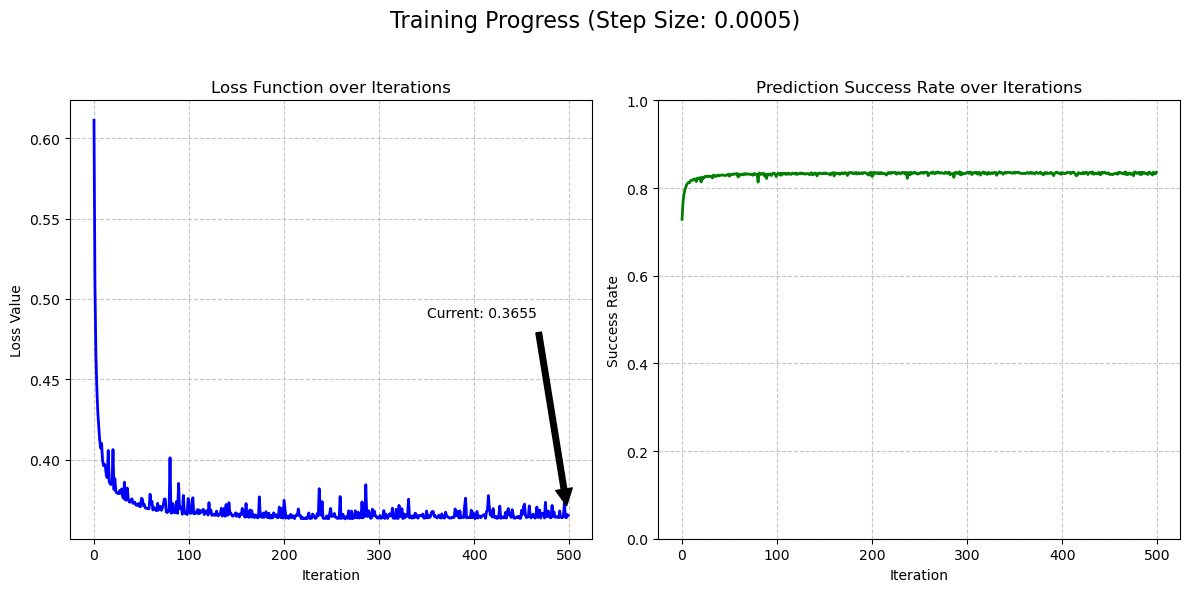

In [19]:
# 可视化部分
model.draw(saveFig=True)

loss = 0.3640, success = 0.8372


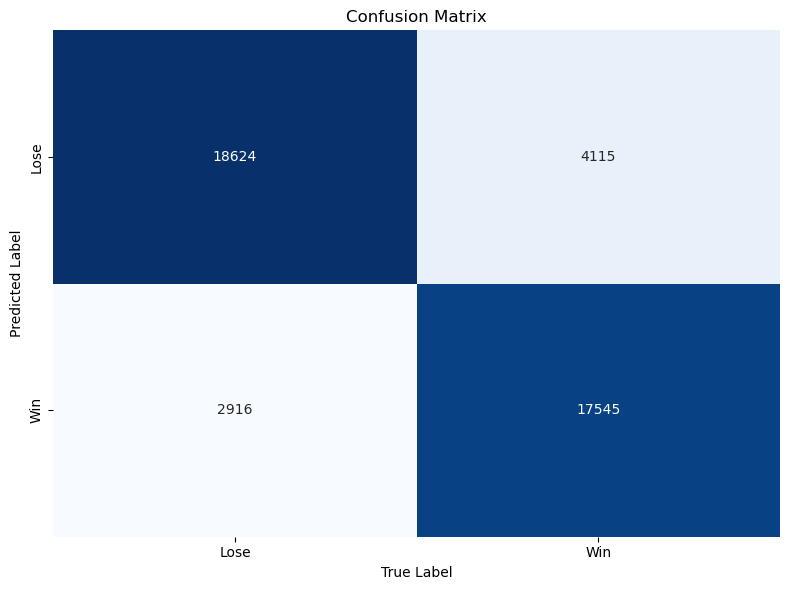

In [20]:
# 获取混淆矩阵
model.parameters = [copy_arrays(array_list) for array_list in model.finest_model]
model.validate(validation)
model.getConfusion(saveFig=True)

In [355]:
# 模型留档，需要根据模型的形状改变下方语句，具体为：wk=model.finest_model[k][0], bk=model.finest_model[k][1] for k in range(model.layer_num)
np.savez("model", w0=model.finest_model[0][0], b0=model.finest_model[0][1],
         w1=model.finest_model[1][0], b1=model.finest_model[1][1],
         # w2=model.finest_model[2][0], b2=model.finest_model[2][1]
        )
print("模型存储成功")

模型存储成功


In [21]:
# 预测部分
basic_data = load_data("test").transpose()
index = np.arange(144000, 180000)
data = model.calculate(basic_data, write=False, dropout=False)
data = (data > 0.5).reshape(-1).astype(int) # 概率大于0.5视为1，小于0.5视为0
writeDown(index, data)

预测结果已保存到 predictions.csv


In [ ]:
# 上面的语句完成后，记得将它和预测结果、模型可视化结果存入同一文件中，方便留档与之后调用